<a href="https://colab.research.google.com/github/AdrienBelanger/451-Project/blob/main/Saca_el_m%C3%A1ximo_partido_de_tu_suscripci%C3%B3n_a_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [2]:
import numpy as np
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Flatten, Add)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt

# Get Data from Yahoo Fiance (Same as Adrien)



In [3]:
dfs = {}  # Dictionary to store data for each ticker
tickers = ['^GSPC']  # S&P 500 index ticker

for ticker in tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], ticker, hist.shape, hist.index.min(), hist.index.max())
    dfs[ticker] = hist

^GSPC S&P 500 ^GSPC (24346, 7) 1927-12-30 00:00:00-05:00 2024-11-29 00:00:00-05:00


# Hyperparameters (Same as Adrien)

In [4]:
# Hyperparameters
SEQUENCE_LENGTH = 15  # Length of the input sequence
TEST_SIZE = 0.2  # Proportion of the dataset to include in the test split
EPOCHS = 20  # Number of training epochs
BATCH_SIZE = 20  # Batch size during training
SHIFT_DAYS = 3  # Days ahead to predict market crashes


Database Creatation (Same as Adrien)

In [5]:
def calculate_drawdown_and_label(data, quantile_threshold=0.005):
    data['daily_return'] = data['Close'].pct_change()
    data['drawdown'] = data['Close'] / data['Close'].cummax() - 1
    crash_threshold = data['drawdown'].quantile(quantile_threshold)
    data['crash_label'] = (data['drawdown'] < crash_threshold).astype(int)
    return data

def prepare_target(data, shift_days=3):
    data['target'] = data['crash_label'].shift(-shift_days)
    data = data.dropna(subset=['target'])
    data['target'] = data['target'].astype(int)
    return data

for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data)
    data = prepare_target(data, SHIFT_DAYS)
    dfs[ticker] = data

<ipython-input-5-1e35cc528317>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].astype(int)


# Preprocesing (Same as Adrien)

In [6]:
def preprocess_data_for_transformer(data, sequence_length=15):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close', 'daily_return', 'drawdown']].dropna())

    X = []
    y = []

    for i in range(len(scaled_data) - sequence_length):
        days = scaled_data[i:i+sequence_length]
        X.append(days)
        y.append(data['target'].iloc[i + sequence_length])

    X = np.array(X)
    y = np.array(y)

    y = y[~np.isnan(y)]
    X = X[:len(y)]
    return X, y, scaler

sequence_length = SEQUENCE_LENGTH
X = {}
y = {}
scalers = {}
for ticker, data in dfs.items():
    X[ticker], y[ticker], scalers[ticker] = preprocess_data_for_transformer(data, sequence_length=sequence_length)

X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=42)

# Model Transformers

In [7]:
def positional_encoding(sequence_length, d_model):
    position = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe = np.zeros((sequence_length, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    pe = pe[np.newaxis, ...]
    return tf.cast(pe, dtype=tf.float32)

def transformer_model(input_shape, num_heads=2, embed_dim=32, ff_dim=64):
    inputs = Input(shape=input_shape)
    x = inputs

    x = Dense(embed_dim)(x)

    sequence_length = input_shape[0]
    positional_encoding_layer = positional_encoding(sequence_length, embed_dim)
    x = x + positional_encoding_layer

    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x, x)
    attention_output = Add()([attention_output, x])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Add()([ffn_output, attention_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

    flatten = Flatten()(ffn_output)
    outputs = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training

In [8]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = transformer_model(input_shape)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9951 - loss: 0.0287 - val_accuracy: 0.9949 - val_loss: 0.0106
Epoch 2/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9950 - loss: 0.0177 - val_accuracy: 0.9990 - val_loss: 0.0043
Epoch 3/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0088 - val_accuracy: 0.9969 - val_loss: 0.0060
Epoch 4/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9975 - loss: 0.0072 - val_accuracy: 0.9963 - val_loss: 0.0089
Epoch 5/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9965 - loss: 0.0072 - val_accuracy: 0.9969 - val_loss: 0.0070
Epoch 6/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9983 - loss: 0.0050 - val_accuracy: 0.9967 - val_loss: 0.0114
Epoch 7/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 8/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9979 - loss: 0.0054 - val_accuracy: 0.

# Metrics (Same as Adrien)

In [9]:
predictions_as_probabilities = model.predict(X_test)
predictions_as_classes = (predictions_as_probabilities > 0.5).astype(int)

accuracy = accuracy_score(y_test, predictions_as_classes)
confusion_matrix_var = confusion_matrix(y_test, predictions_as_classes)

print(f"Test Accuracy: {accuracy}")

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Accuracy: 0.9993834771886559


# Plotting (Same as Adrien)

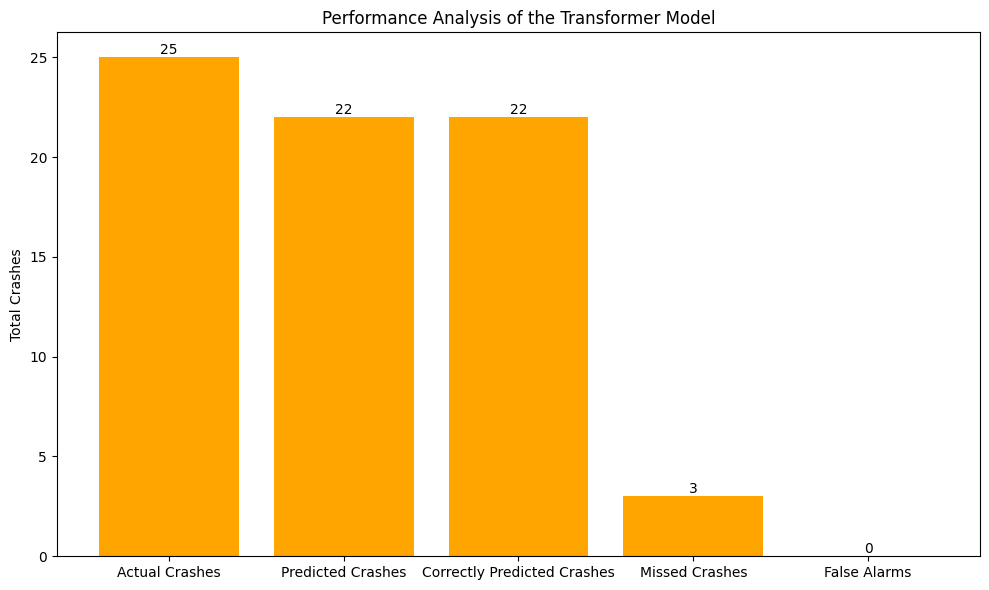

In [10]:
real_crashes = int(sum(y_test == 1))
predicted_crashes = int((predictions_as_classes == 1).sum())
predicted_correctly = int(confusion_matrix_var[1, 1])
missed_crashes = int(confusion_matrix_var[1, 0])
predicted_when_there_wasnt = int(confusion_matrix_var[0, 1])

categories = [
    "Actual Crashes",
    "Predicted Crashes",
    "Correctly Predicted Crashes",
    "Missed Crashes",
    "False Alarms"
]
values = [
    real_crashes,
    predicted_crashes,
    predicted_correctly,
    missed_crashes,
    predicted_when_there_wasnt,
]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color='orange')
plt.title("Performance Analysis of the Transformer Model")
plt.ylabel("Total Crashes")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
